In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from termcolor import colored
import pathlib
import time
import sys
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing the data

Here, we prepare the input for the ``RosieCorpus`` class using the KidHealth data format. This means we have a theoretically aligned corpus, so no translations are needed. If we did not have aligned documents, we would need to translate every document in the English corpus into Spanish, and vice versa.

We first load the passages-split versions of each corpus and get the "english" version of the URL in the Spanish corpus for alignment.

In [2]:
df_en = pd.read_json("data/kidshealth_en_2172025/corpus_strict_v.en_compiled_passages.jsonl", lines=True)
df_es = pd.read_json("data/kidshealth_es_2172025/corpus_strict_vv.es_compiled_passages.jsonl", lines=True)

# get "english" version of the URL in the Spanish corpus for alignment
df_es["en_url"] = df_es["url"].apply(lambda x: x.replace("/es/", "/en/"))

print(df_en.shape)
print(df_es.shape)

(25592, 4)
(37641, 5)


Since the number of passages per URL in the English corpus differs from that in the Spanish corpus (see image below), we restrict the number of passages per URL to match the language with fewer passages-in this case, the English corpus. Then, we attempt to align each passage in the English corpus for a given URL with the best candidate from the Spanish corpus.

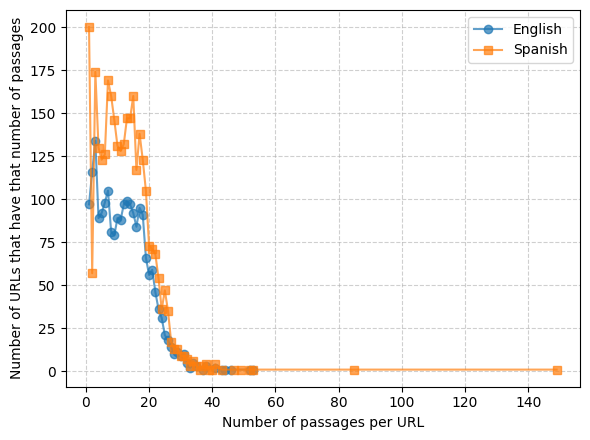

In [3]:
import matplotlib.pyplot as plt

en_counts = df_en.groupby("url").size()
es_counts = df_es.groupby("en_url").size()

en_distribution = en_counts.value_counts().sort_index()
es_distribution = es_counts.value_counts().sort_index()

plt.figure(figsize=(6, 4.5)) 
plt.plot(en_distribution.index, en_distribution.values, 'o-', label="English", alpha=0.7)
plt.plot(es_distribution.index, es_distribution.values, 's-', label="Spanish", alpha=0.7)

# Labels and title
plt.xlabel("Number of passages per URL")  
plt.ylabel("Number of URLs that have that number of passages")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [4]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

aligned_paragraphs = []

doc_urls = list(set(df_en["url"]).intersection(set(df_es["en_url"])))

for url in tqdm(doc_urls):
    try:
        en_passages = df_en[df_en["url"] == url]["passage"].tolist()
        es_passages = df_es[df_es["en_url"] == url]["passage"].tolist()

        en_vectors = model.encode(en_passages)
        es_vectors = model.encode(es_passages)

        similarity_matrix = cosine_similarity(en_vectors, es_vectors)

        for i, en_paragraph in enumerate(en_passages):
            best_match_idx = np.argmax(similarity_matrix[i])

            aligned_paragraphs.append({
                "url": url,
                "english_orig_idx": df_en[(df_en["url"] == url) & (df_en["passage"] == en_paragraph)].passage_id.values[0],
                "spanish_orig_idx": df_es[(df_es["en_url"] == url) & (df_es["passage"] == es_passages[best_match_idx])].passage_id.values[0],
                "english_passage": en_paragraph,
                "spanish_passage": es_passages[best_match_idx],
                "similarity_score": similarity_matrix[i][best_match_idx],
            })
    except Exception as e:
        print(f"Error processing {url}: {e}")
        
df_aligned = pd.DataFrame(aligned_paragraphs)
df_aligned


100%|██████████| 1860/1860 [06:13<00:00,  4.97it/s]


,url,english_orig_idx,spanish_orig_idx,english_passage,spanish_passage,similarity_score
0,https://kidshealth.org/en/teens/therapist.html,711-0,2131-7,What Is Therapy: Therapy is a way to get help ...,¿Por qué la gente necesita terapia: La gente n...,0.743729
1,https://kidshealth.org/en/teens/therapist.html,711-1,2131-1,"If you go to therapy, you'll have meetings wit...",El terapeuta te hará preguntas y te escuchará....,0.837223
2,https://kidshealth.org/en/teens/therapist.html,711-2,2131-3,What Problems Do Therapists Help With: Therapi...,¿En qué tipo de problemas ayudan los terapeuta...,0.913173
3,https://kidshealth.org/en/teens/therapist.html,711-3,2131-6,They help people who are going through tough t...,Ayudan en afecciones como:\n- el TDAH\n- la de...,0.702496
4,https://kidshealth.org/en/teens/therapist.html,711-4,2131-4,They help people who have been through things ...,Los terapeutas ayudan a la gente a superar mom...,0.701172
...,...,...,...,...,...,...
23590,https://kidshealth.org/en/kids/sleepwalking.html,1845-6,3042-6,What Will the Doctor Do: There's no cure for s...,¿Qué hará el médico: El sonambulismo no se pue...,0.772493
23591,https://kidshealth.org/en/kids/sleepwalking.html,1845-7,3042-7,"For kids who sleepwalk often, doctors may reco...",A aquellos niños que tienen episodios de sonam...,0.736813
23592,https://kidshealth.org/en/kids/sleepwalking.html,1845-8,3042-8,Here are some tips to help prevent sleepwalkin...,He aquí algunos consejos que pueden ayudarte a...,0.780104
23593,https://kidshealth.org/en/kids/sleepwalking.html,1845-9,3042-9,How to Take Care of a Sleepwalker: One thing y...,Cómo ayudar a un sonámbulo: Una de las cosas q...,0.768610


array([[<Axes: title={'center': 'similarity_score'}>]], dtype=object)

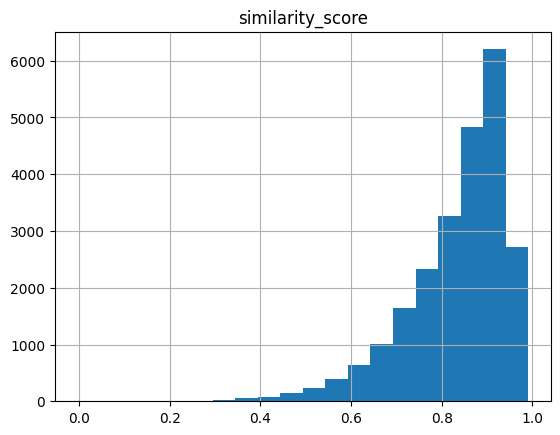

In [5]:
df_aligned.hist("similarity_score", bins=20)

We keep half of the URLs as "English original passages" and the other half as "Spanish original passages". Here, we aim to mimic a real scenario where aligned documents are not available, requiring translations to be carried out. After dividing the data, we ensure good matching by retaining only pairs with a similarity score greater than 0.8. Note that this would not occur in a real scenario, as we would either have properly aligned fragments at the passage level or translated documents to obtain their counterparts. 

In [6]:
# each df must have the following columns:
# Index(['passage_id', 'passage', 'title', 'url', 'lang', 'tr_text'], dtype='object')

# for this we assume that half of the urls belong to the english dataset and the other half to the spanish dataset
nr_urls = len(doc_urls) // 2
df_en = df_aligned[df_aligned["url"].isin(doc_urls[:nr_urls])].copy()
df_es = df_aligned[df_aligned["url"].isin(doc_urls[nr_urls:])].copy()

df_en.loc[:, "lang"] = "eng_Latn"
df_es.loc[:, "lang"] = "spa_Latn"

df_en = df_en.rename(
    columns={
        "english_orig_idx": "passage_id",
        "english_passage": "passage", 
        "spanish_passage": "tr_text", 
    }
)
df_es = df_es.rename(
    columns={
        "spanish_orig_idx": "passage_id",
        "spanish_passage": "passage", 
        "english_passage": "tr_text", 
    }
)

# filter by similarity larger than thr
thr = 0.8
df_en = df_en[df_en["similarity_score"] > thr]
df_es = df_es[df_es["similarity_score"] > thr]

df_en = df_en[["passage_id", "passage", "url", "lang", "tr_text"]]
df_es = df_es[["passage_id", "passage", "url", "lang", "tr_text"]]

path_corpus_en = "data/kidshealth/corpus_pass_aligned_en.parquet"
df_en.to_parquet(path_corpus_en)
path_corpus_es = "data/kidshealth/corpus_pass_aligned_es.parquet"
df_es.to_parquet(path_corpus_es)
df_en

,passage_id,passage,url,lang,tr_text
1,711-1,"If you go to therapy, you'll have meetings wit...",https://kidshealth.org/en/teens/therapist.html,eng_Latn,El terapeuta te hará preguntas y te escuchará....
2,711-2,What Problems Do Therapists Help With: Therapi...,https://kidshealth.org/en/teens/therapist.html,eng_Latn,¿En qué tipo de problemas ayudan los terapeuta...
5,711-5,They help people work out difficult feelings l...,https://kidshealth.org/en/teens/therapist.html,eng_Latn,Ayudan a la gente a afrontar sentimientos dolo...
6,711-7,"What Happens in Therapy: In therapy, people me...",https://kidshealth.org/en/teens/therapist.html,eng_Latn,"¿Qué ocurre en terapia: Al principio, tu terap..."
7,711-8,"At the beginning, the therapist asks questions...",https://kidshealth.org/en/teens/therapist.html,eng_Latn,El terapeuta te hará preguntas y te escuchará....
...,...,...,...,...,...
11637,1415-2,Most toddlers do well with three meals and two...,https://kidshealth.org/en/parents/toddler-snac...,eng_Latn,La mayoría de los niños pequeños funcionan bie...
11640,1415-5,Make Healthy Snacking a Habit: Toddlers will e...,https://kidshealth.org/en/parents/toddler-snac...,eng_Latn,Convierta los tentempiés saludables en un hábi...
11641,1415-6,"To help toddlers eat healthy:\n- Make sweets, ...",https://kidshealth.org/en/parents/toddler-snac...,eng_Latn,Para ayudar a los niños pequeños a comer sano:...
11642,1762-0,What's an MRI (Magnetic Resonance Imaging): An...,https://kidshealth.org/en/parents/mri.html,eng_Latn,¿Qué es una resonancia magnética (imagen por r...


# Generate ROSIE corpus

The `RosieCorpus` class expects the paths to two Parquet files—one per language—as input. Here, these files are the Parquet files generated in the previous cell. Each dataframe must contain the following columns: `passage_id`, `passage`, `title`, `url`, `lang`, and `tr_text`.  

The `lang` column should be formatted as `"eng_Latn"` or `"spa_Latn"`. If additional languages or an alternative formatting are required, the class would need to be modified.  

The `RosieCorpus` class handles preprocessing for us, so the generated output file (`path_save`) already contains all the necessary information—lemmas and translated lemmas—needed for training the model.  

In [7]:
from src.corpus_building.rosie_corpus import RosieCorpus

path_corpus_en = "data/kidshealth/corpus_pass_aligned_en.parquet"
path_corpus_es = "data/kidshealth/corpus_pass_aligned_es.parquet"
path_save_tr = pathlib.Path(path_corpus_en).parent / "df.parquet"

sample=1
rosie_corpus = RosieCorpus(path_corpus_en, path_corpus_es)
path_save = rosie_corpus.generate_tm_tr_corpus(path_save_tr, level="passage", sample=sample)

path_save_models = pathlib.Path(path_save).parent / "models"
os.makedirs(path_save_models, exist_ok=True)

2025-02-27 15:00:39,879 - src.corpus_building.rosie_corpus - INFO - -- -- Reading data from data/kidshealth/corpus_pass_aligned_en.parquet and data/kidshealth/corpus_pass_aligned_es.parquet
2025-02-27 15:00:39,970 - src.corpus_building.rosie_corpus - INFO - -- -- 8175 elements read from data/kidshealth/corpus_pass_aligned_en.parquet
2025-02-27 15:00:40,039 - src.corpus_building.rosie_corpus - INFO - -- -- 8408 elements read from data/kidshealth/corpus_pass_aligned_es.parquet
2025-02-27 15:00:40,042 - src.corpus_building.rosie_corpus - INFO - -- Training corpus for sample 1 and level passage already exists. Loading from data/kidshealth/df_1.parquet...


# Train the Model  

To train the model, we simply specify the languages to be used, the path for saving the models, and the number of topics.  

In [8]:
from src.topic_modeling.polylingual_tm import PolylingualTM

for k in [5, 10, 20, 30]:
    model = PolylingualTM(
        lang1="EN",
        lang2="ES",
        model_folder= path_save_models / f"poly_rosie_{str(sample)}_{k}",
        num_topics=k
    )
    model.train(path_save)

2025-02-27 15:00:40,070 - PolylingualTM - INFO - -- -- Given model folder data/kidshealth/models/poly_rosie_1_5 already exists. Saving a copy ...
INFO:PolylingualTM:-- -- Given model folder data/kidshealth/models/poly_rosie_1_5 already exists. Saving a copy ...
2025-02-27 15:00:40,231 - PolylingualTM - INFO - -- -- Creating Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_EN.txt...
INFO:PolylingualTM:-- -- Creating Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_EN.txt...
2025-02-27 15:00:40,280 - PolylingualTM - INFO - -- -- Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_EN.txt created.
INFO:PolylingualTM:-- -- Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_EN.txt created.
2025-02-27 15:00:40,287 - PolylingualTM - INFO - -- -- Creating Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_ES.txt...
INFO:PolylingualTM:-- -- Creating Mallet data/kidshealth/models/poly_rosie_1_5/train_data/corpus_ES.txt...
2025-02-27 1

### Obtain Keywords, Identify Representative Topics per Document, and Generate Topic Labels  

From this point onwards, we will further explore the models constructed with five topics, though other models could also be used.  

First, we extract the most representative topics for each document and identify the topic keywords—the most probable words characterizing each topic. Additionally, we can generate a label for each topic in the model. For this, we use the topic keys in English, though the Spanish ones could also be used.  

To generate the labels, we prompt a large language model (LLM)—in this case, GPT-3.5. However, this can be updated to use local open-source models instead. The prompt includes the topic keys and representative documents for each topic. Below is an example of the prompt used.  

```
You are given a set of keywords and five passages, each centered around a common topic. Your task is to analyze both the keywords and the content of the documents to create a clear, concise label that accurately reflects the overall theme they share. The label:  
- Must not be or include the word "LABEL".
- Must match the language of the keywords.
- Should be broad yet relevant, capturing the overall theme in a general way rather than focusing on specific components or processes

Your response should **only** be the label (no additional text).  

Keywords: baby technology body eye ear brain bone blood muscle heart birth grow happen skin pregnancy month sound head hear
Documents: 
The Inner Ear: The vibrations from the middle ear change into nerve signals in the inner ear. The inner ear includes the cochlea (pronounced: KOH-klee-uh) and the semicircular canals. The snail-shaped cochlea changes the vibrations from the middle ear into nerve signals. These signals travel to the brain along the cochlear nerve, also known as the auditory nerve.
But sometimes the electrical signals are abnormal, and the heart can start beating in a different rhythm — this is an arrhythmia (also called dysrhythmia).
Sometimes, the eyelid doesn't open at all. Ptosis can affect one eye or both eyes.
A baby with a cleft might have:\n- only a cleft palate\n- only a cleft lip\n- both a cleft lip and a cleft palate.
What Are Ears and What Do They Do: The ear is made up of three different sections that work together to collect sounds and send them to the brain: the outer ear, the middle ear, and the inner ear.
Label:
```

In [9]:
from src.graphs.preparation.prepare_poly_output import initialize_gpt_model, load_environment_variables, load_prompt_template
from scipy import sparse
from src.graphs.preparation.prepare_poly_output import get_doc_top_tpcs, get_doc_main_topc, get_most_representative_per_tpc

api_key = load_environment_variables()
gpt_model = initialize_gpt_model(api_key)
prompt_template = load_prompt_template("src/graphs/preparation/prompt_labels.txt")

path_save_tr_sample = path_save.parent / f"df_{sample}.parquet"
k = 5
model_path = path_save_models / f"poly_rosie_{str(sample)}_{k}"
df = pd.read_parquet(path_save_tr_sample)

# Add length of the text, thetas (document-topic distribution), top_k (top k topics), main_topic (main topic)
df["len"] = df['lemmas'].apply(lambda x: len(x.split()))

thetas_en = sparse.load_npz(model_path / "mallet_output" / "thetas_EN.npz").toarray()
thetas_es = sparse.load_npz(model_path / "mallet_output" / "thetas_ES.npz").toarray()
s3_en = sparse.load_npz(model_path / "mallet_output" / "s3_EN.npz").toarray()
s3_es = sparse.load_npz(model_path / "mallet_output" / "s3_ES.npz").toarray()

top_docs_per_topic_en = get_most_representative_per_tpc(thetas_en, topn=5, thr=0)
top_docs_per_topic_es = get_most_representative_per_tpc(s3_es, topn=10, thr=0)


raw_en = df[df.doc_id.str.contains("EN")].copy()
raw_en["thetas"] = list(thetas_en)
raw_en["top_k"] = raw_en["thetas"].apply(get_doc_top_tpcs)
raw_en["main_topic"] = raw_en["thetas"].apply(get_doc_main_topc)

raw_es = df[df.doc_id.str.contains("ES")].copy()
raw_es["thetas"] = list(thetas_es)
raw_es["top_k"] = raw_es["thetas"].apply(get_doc_top_tpcs)
raw_es["main_topic"] = raw_es["thetas"].apply(get_doc_main_topc)

# Get topic keys (English)
with open(model_path / "mallet_output" / "keys_EN.txt", 'r') as file: lines = file.readlines()
topic_keys = [line.strip() for line in lines]
for i, key in enumerate(topic_keys):
    print(f"{i}: {key}")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lbartolome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/lbartolome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lbartolome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lbartolome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lbartolome/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/lbartolome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


/export/usuarios_ml4ds/lbartolome/.env
Threshold: 0
Threshold: 0
0: baby doctor health child care organization pregnancy month medical grow technology growth birth talk week provider change hospital woman
1: technology kid feel child time parent school talk health people learn organization teen friend family stress support teacher play
2: food eat technology sleep drink baby healthy kid milk exercise day child sport time sugar body fat level formula
3: technology eye skin ear body bone brain hand muscle injury blood happen head clean wear heart wash pain water
4: technology symptom infection doctor medicine people blood child vaccine disease health kid body organization person virus cell pain treat


In [10]:
tpc_labels = []
for id_tpc, tpc in enumerate(topic_keys):
    this_tpc_prompt = prompt_template.format(keywords=tpc, docs="\n"+"\n".join(raw_en.iloc[top_docs_per_topic_en[id_tpc]].text.values.tolist()))
    print(f"Topic: {tpc}")
    llm_response = gpt_model.prompt_gpt(prompt=this_tpc_prompt, model_engine='gpt-3.5-turbo', temperature=1, max_tokens=10)# 2-5 words
    tpc_labels.append(llm_response)
    print(f"Label: {llm_response}")

Topic: baby doctor health child care organization pregnancy month medical grow technology growth birth talk week provider change hospital woman


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Label: Health and Pregnancy
Topic: technology kid feel child time parent school talk health people learn organization teen friend family stress support teacher play


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Label: Emotional Well-Being
Topic: food eat technology sleep drink baby healthy kid milk exercise day child sport time sugar body fat level formula


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Label: Nutrition
Topic: technology eye skin ear body bone brain hand muscle injury blood happen head clean wear heart wash pain water


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Label: Body Systems
Topic: technology symptom infection doctor medicine people blood child vaccine disease health kid body organization person virus cell pain treat


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Label: Illness


In [11]:
with open(model_path / "mallet_output" / "tpc_labels.txt", 'w') as file:
    file.write("\n".join(tpc_labels))
    
raw_en.loc[:, "label"] = raw_en["main_topic"].apply(lambda x: tpc_labels[x])
raw_es.loc[:, "label"] = raw_es["main_topic"].apply(lambda x: tpc_labels[x])


raw_en.to_parquet(model_path  / "df_en_with_model_info.parquet")
raw_es.to_parquet(model_path / "df_es_with_model_info.parquet")

raw_en

,id_preproc,lemmas,lemmas_tr,doc_id,text,text_tr,lang,len,thetas,top_k,main_topic,label
0,0,body look_crooked different information_techno...,cuerpo torcido distinto lesión,EN_2551_1931-4,Sometimes the body part looks crooked or diffe...,"A veces, la parte del cuerpo se ve torcida o d...",EN,5,"[0.125, 0.0, 0.0, 0.75, 0.125]","[(3, 0.75), (4, 0.125)]",3,Body Systems
1,1,fever pain doctor_suggest counter medicine ace...,fiebre dolor médico sugerirte medicamento_vent...,EN_331_1433-17,"For fever and pain, your doctor may suggest an...","Para la fiebre y el dolor, tu médico puede sug...",EN,8,"[0.13043478228475736, 0.08695652400669845, 0.3...","[(4, 0.4782608783115512), (2, 0.30434781539699...",4,Illness
2,2,student mono need miss_school homework assignm...,alumno mononucleosis faltar_clase deber_tarea ...,EN_8197_1210-4,Students with mono might need to:\n- miss scho...,Los alumnos con mononucleosis pueden necesitar...,EN,24,"[0.10869564759828479, 0.4999999953433872, 0.04...","[(1, 0.4999999953433872), (4, 0.32608696514659...",1,Emotional Well-Being
3,3,ask friend world_health organization talk suic...,pregúntalir amigo hablar suicidio mostrar seña...,EN_6592_964-3,Ask: If you have a friend who's talking about ...,Pregúntale: Si tienes un amigo que está hablan...,EN,20,"[0.0263157890815484, 0.9473684218369032, 0.0, ...","[(1, 0.9473684218369032), (4, 0.02631578908154...",1,Emotional Well-Being
4,4,succeed close eye imagine complete pass shot s...,tratar ver tú éxito cerrar ojo imaginar pase t...,EN_4406_1051-6,You can also try to “see” yourself succeeding....,"También puedes tratar de ""verte"" teniendo éxit...",EN,13,"[0.0, 0.7500000027939677, 0.04166666806365053,...","[(1, 0.7500000027939677), (3, 0.20833332914238...",1,Emotional Well-Being
...,...,...,...,...,...,...,...,...,...,...,...,...
8459,8459,happen baby growth_slow baby big child tall_sh...,bebé crecer bebé hijo alto padre preocupar cre...,EN_5957_169-4,What Happens if My Baby’s Growth Is Slow: Is m...,¿Qué ocurre si mi bebé crece lentamente: ¿Es l...,EN,21,"[0.8979591844337327, 0.04081632622650691, 0.0,...","[(0, 0.8979591844337327), (1, 0.04081632622650...",0,Health and Pregnancy
8460,8460,tampon tampon vagina applicator finger wash_ha...,tampón tampón introducir_vagina aplicador dedo...,EN_1014_1251-12,How Do You Use Tampons: A tampon is put into t...,¿Cómo se usan los tampones: El tampón se intro...,EN,10,"[0.037037036209194775, 0.11111110862758432, 0....","[(3, 0.8518518551632209), (1, 0.11111110862758...",3,Body Systems
8461,8461,broken_bones treat doctor treat broken_bone ca...,tratar fractura médico tratar mayoría fractura...,EN_2130_1941-6,How Are Broken Bones Treated: Doctors treat mo...,¿Cómo se tratan las fracturas: Los médicos tra...,EN,16,"[0.15217391024951046, 0.021739131366105207, 0....","[(3, 0.8260869583843843), (0, 0.15217391024951...",3,Body Systems
8462,8462,allergy allergy abnormal immune_system reactio...,alergia alergia reacción anormal sistema_inmun...,EN_5261_1748-0,What Are Allergies: Allergies are abnormal imm...,¿Qué son las alergias: Las alergias son reacci...,EN,23,"[0.04255318927003987, 0.021276594635019935, 0....","[(4, 0.7872340517871556), (2, 0.08510637854007...",4,Illness


## Hierarchical Topic Models

We have two types of hierarchical topic models: **HTM-WS** and **HTM-DS**. These models involve the user in deciding which topics need to be split further. Instead of automatically creating subtopics for every topic, the user can inspect the initial model and choose which topics to expand. This approach makes it easier to incorporate expert knowledge into the model.

Both methods start with a first-level (L1) topic model and then build the second level by focusing on one of the L1 topics. Here's how they work:

- **HTM-WS**: Creates new documents by keeping only the words related to the chosen topic.
- **HTM-DS**: Keeps only the documents where the chosen topic is a major part.

The main difference is:

- **HTM-WS** assigns each word to just one subtopic, giving a clear, detailed breakdown of topics.
- **HTM-DS** allows different full documents to be included in different submodels, which can be useful for understanding how entire documents fit into subtopics.

In short, **HTM-WS** provides a detailed and precise breakdown of topics, while **HTM-DS** offers a way to explore how entire documents relate to subtopics, even if it's less precise.

In [12]:
from src.topic_modeling.hierarchical.hierarchical_tm import HierarchicalTM
from src.topic_modeling.polylingual_tm import PolylingualTM

mallet_path = "src/topic_modeling/Mallet-202108/bin/mallet"
path_stops = "src/topic_modeling/stops"

In [13]:
lang_colors = {
    "EN": "red",
    "ES": "blue",
}

## Father model 

A first-level multilingual topic model should be trained initially. While it's possible to create a script that integrates everything at once, the second level is better suited for an exploratory step based on the first-level topic model.

For this example, we are going to generate a second-level model from one of the topics from the model (``model_path``) analyzed in the previous step.

In [14]:
father_model = model_path

### Father model topics

We first present the topics in the parent model. These topics are common to both languages, with corresponding keys for each language. The topics are aligned, although the words in each topic are not literal translations between the languages.

In [15]:
# father model
father_model = pathlib.Path(father_model)
langs = ["EN", "ES"]

hmg = HierarchicalTM()

# Load topic-keys in each lang
all_keys = {}
for lang in langs:
    # Default to white if color is not defined
    color = lang_colors.get(lang, "white")
    print(colored("#" * 50, color))
    print(colored(f"-- -- Topic keys in {lang.upper()}: ", color))
    print(colored("-" * 50, color))
    keys = []
    with (father_model / f"mallet_output/keys_{lang}.txt").open('r', encoding='utf8') as fin:
        keys = [el.strip() for el in fin.readlines()]
    all_keys[lang] = keys
    for id, tpc in enumerate(keys):
        print(colored(f"- Topic {id}: {tpc}", color))
    print("\n")

##################################################
-- -- Topic keys in EN: 
--------------------------------------------------
- Topic 0: baby doctor health child care organization pregnancy month medical grow technology growth birth talk week provider change hospital woman
- Topic 1: technology kid feel child time parent school talk health people learn organization teen friend family stress support teacher play
- Topic 2: food eat technology sleep drink baby healthy kid milk exercise day child sport time sugar body fat level formula
- Topic 3: technology eye skin ear body bone brain hand muscle injury blood happen head clean wear heart wash pain water
- Topic 4: technology symptom infection doctor medicine people blood child vaccine disease health kid body organization person virus cell pain treat


##################################################
-- -- Topic keys in ES: 
--------------------------------------------------
- Topic 0: bebé médico hijo problema niño salud embarazo prue

### Get input from the user on the construction of the 2nd level topic model

We need the following information from the user:

- The topic to be "expanded" to construct the 2nd level topic model
- The algorithm to be used for constructing the 2nd level topic model
- If using HTM-DS, the threshold value
- The number of training topics for the 2nd level model

In [16]:
# ask input from user: he needs to select a topic id
topic_id = input(f"Please select the topic you want to expand: ")
try:
    topic_id = int(topic_id)
    if topic_id < 0 or topic_id >= len(keys):
        raise ValueError("Topic id out of range.")
    print(f"Selected Topic {topic_id}: {all_keys[langs[0]][topic_id]}")
    for lang in langs:
        color = lang_colors.get(lang, "white")
        print(
            colored(f"Keys in {lang}: {all_keys[lang][topic_id]}", color))
except ValueError as e:
    print(f"Invalid input: {e}")
    sys.exit()

# htm version
htm_version = input(f"Please select the method you want to use (htm_ws/htm_ds): ")
if htm_version not in ["htm_ds", "htm_ws"]:
    raise ValueError("Invalid method")

# thr if ds
thr = 0.0
if htm_version == "htm_ds":
    thr = input("Please insert the threshold: ")
    try:
        thr = float(thr)
    except:
        print(f"Invalid input: {e}")
        sys.exit()
# ask input from user: he needs to select a topic id
tr_tpcs = input(f"Please select the number of training topics for the submodel: ")
try:
    tr_tpcs = int(tr_tpcs)
except ValueError as e:
    print(f"Invalid input: {e}")
    sys.exit()

Selected Topic 0: baby doctor health child care organization pregnancy month medical grow technology growth birth talk week provider change hospital woman
Keys in EN: baby doctor health child care organization pregnancy month medical grow technology growth birth talk week provider change hospital woman
Keys in ES: bebé médico hijo problema niño salud embarazo prueba mes crecer crecimiento año profesional mujer cuidado edad sexual soler nacer


### Train the model

In [17]:
submodel_path = hmg.create_submodel_tr_corpus(
    father_model_path=father_model,
    langs=langs,
    exp_tpc=topic_id,
    tr_topics=tr_tpcs,
    htm_version=htm_version,
    thr=thr)

# train model
start_time = time.time()
model = PolylingualTM(
    mallet_path=mallet_path,
    lang1=langs[0],
    lang2=langs[1],
    model_folder= submodel_path,
    num_topics=tr_tpcs,
    is_second_level=True,
    add_stops_path=path_stops
)
model.train()

end_time = time.time()
print(f"-- Model trained in {end_time - start_time} seconds")

INFO:src.topic_modeling.hierarchical.hierarchical_tm:-- -- Creating training corpus according to HTM-WS.
/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/topic_modeling/hierarchical/hierarchical_tm.py:136: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  topic_state_df = pd.read_csv(
/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/topic_modeling/hierarchical/hierarchical_tm.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_to_corpus_lang['new'] = topic_to_corpus_lang['new'].apply(lambda x: [i for i in x if pd.notna(i)])


Pandas(Index=0, docid=0, lang=0, new=[])
Pandas(Index=2, docid=1, lang=0, new=['doctor'])
Pandas(Index=4, docid=2, lang=0, new=[])
Pandas(Index=6, docid=3, lang=0, new=[])
Pandas(Index=8, docid=5, lang=0, new=['specialist', 'specialist'])
Pandas(Index=10, docid=6, lang=0, new=['risk'])
Pandas(Index=12, docid=7, lang=0, new=['comfort', 'baby', 'baby', 'cuddle', 'baby'])
Pandas(Index=14, docid=8, lang=0, new=[])
Pandas(Index=16, docid=9, lang=0, new=['newborn', 'position', 'baby', 'bear', 'weight', 'grow'])
Pandas(Index=18, docid=10, lang=0, new=['day'])
Pandas(Index=20, docid=11, lang=0, new=[])
Pandas(Index=22, docid=13, lang=0, new=['child'])
Pandas(Index=24, docid=14, lang=0, new=[])
Pandas(Index=26, docid=16, lang=0, new=[])
Pandas(Index=28, docid=18, lang=0, new=[])
Pandas(Index=30, docid=19, lang=0, new=['exam', 'technician', 'child', 'child', 'sedation', 'recovery', 'sedation'])
Pandas(Index=32, docid=21, lang=0, new=['diagnose', 'doctor', 'exam', 'medical', 'history'])
Pandas(In

2025-02-27 15:11:56,536 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:11:56,536 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:11:56,536 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:11:56,536 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:11:56,536 - PolylingualTM - INFO - -- -- Importing data to Mallet...
INFO:PolylingualTM:-- -- Importing data to Mallet...
2025-02-27 15:11:56,539 - PolylingualTM - INFO - -- -- Running command src/topic_modeling/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\p{L}+" --print-output --input data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/train_data/corpus_EN.txt --output data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/mallet_input/corpus_EN.mallet --extra-stopwords src/topic_modeling/stops/en.txt
2025-02-27 15:11:56,539 - Polyling

Processing lang:  EN
data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/train_data/corpus_EN.txt
Processing lang:  ES
data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/train_data/corpus_ES.txt


2025-02-27 15:11:58,433 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:11:58,433 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:11:58,433 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:11:58,433 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:11:58,433 - PolylingualTM - INFO - -- -- Data imported to Mallet.
INFO:PolylingualTM:-- -- Data imported to Mallet.
2025-02-27 15:11:58,436 - PolylingualTM - INFO - -- -- Running command src/topic_modeling/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\p{L}+" --print-output --input data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/train_data/corpus_ES.txt --output data/kidshealth/models/poly_rosie_1_5/submodels/htm_ws_from_tpc_0_train_with_10/mallet_input/corpus_ES.mallet --extra-stopwords src/topic_modeling/stops/es.txt
2025-02-27 15:11:58,436 - PolylingualTM - INFO - -- 

-- Model trained in 22.61733341217041 seconds


### Topics at the 2nd-level for the expanded topic (HTM-WS)

Below are the topics obtained from training the HTM-DS model.

In [18]:
# Display topics of the submodel 
# Load topic-keys in each lang
submodel_ws_path = submodel_path
all_keys = {}
for lang in langs:
    # Default to white if color is not defined
    color = lang_colors.get(lang, "white")
    print(colored("#" * 50, color))
    print(colored(f"-- -- Topic keys in {lang.upper()}: ", color))
    print(colored("-" * 50, color))
    keys = []
    with (submodel_ws_path / f"mallet_output/keys_{lang}.txt").open('r', encoding='utf8') as fin:
        keys = [el.strip() for el in fin.readlines()]
    all_keys[lang] = keys
    for id, tpc in enumerate(keys):
        print(colored(f"- Topic {id}: {tpc}", color))
    print("\n")

##################################################
-- -- Topic keys in EN: 
--------------------------------------------------
- Topic 0: grow growth weight baby age doctor gain normal month child rate development slow develop check height body continue short
- Topic 1: baby month breastfeed sound start infant talk respond breast age crib sign change hear feed continue voice watch time
- Topic 2: pregnancy baby woman pregnant birth health risk week labor mother prenatal delivery organization fetus fetal technology uterus trimester develop
- Topic 3: doctor child talk surgery question anesthesia concern medicine care technology procedure medical emergency risk happen patient decide time nurse
- Topic 4: care health doctor provider hospital medical child visit nurse team record office check center patient family medicine follow organization
- Topic 5: baby newborn bear week birth health organization technology month care infant heart life mother hour defect congenital day develop
- Topic

### Topics at the 2nd-level for the expanded topic (HTM-DS)


For comparison, we show the topics obtained by training an HTM-DS model for the same expansion topic.

In [19]:
# ask input from user: he needs to select a topic id
topic_id = input(f"Please select the topic you want to expand: ")
try:
    topic_id = int(topic_id)
    if topic_id < 0 or topic_id >= len(keys):
        raise ValueError("Topic id out of range.")
    print(f"Selected Topic {topic_id}: {all_keys[langs[0]][topic_id]}")
    for lang in langs:
        color = lang_colors.get(lang, "white")
        print(
            colored(f"Keys in {lang}: {all_keys[lang][topic_id]}", color))
except ValueError as e:
    print(f"Invalid input: {e}")
    sys.exit()

# htm version
htm_version = input(f"Please select the method you want to use (htm_ws/htm_ds): ")
if htm_version not in ["htm_ds", "htm_ws"]:
    raise ValueError("Invalid method")

# thr if ds
thr = 0.0
if htm_version == "htm_ds":
    thr = input("Please insert the threshold: ")
    try:
        thr = float(thr)
    except:
        print(f"Invalid input: {e}")
        sys.exit()
# ask input from user: he needs to select a topic id
tr_tpcs = input(f"Please select the number of training topics for the submodel: ")
try:
    tr_tpcs = int(tr_tpcs)
except ValueError as e:
    print(f"Invalid input: {e}")
    sys.exit()

Selected Topic 0: grow growth weight baby age doctor gain normal month child rate development slow develop check height body continue short
Keys in EN: grow growth weight baby age doctor gain normal month child rate development slow develop check height body continue short
Keys in ES: crecimiento crecer bebé peso niño edad año ritmo normal mes médico estatura mayoría hijo soler medida forma alto seguir


In [20]:
submodel_path = hmg.create_submodel_tr_corpus(
    father_model_path=father_model,
    langs=langs,
    exp_tpc=topic_id,
    tr_topics=tr_tpcs,
    htm_version=htm_version,
    thr=thr)

# train model
start_time = time.time()
model = PolylingualTM(
    mallet_path=mallet_path,
    lang1=langs[0],
    lang2=langs[1],
    model_folder= submodel_path,
    num_topics=tr_tpcs,
    is_second_level=True,
    add_stops_path=path_stops
)
model.train()

end_time = time.time()
print(f"-- Model trained in {end_time - start_time} seconds")

INFO:src.topic_modeling.hierarchical.hierarchical_tm:-- -- Creating training corpus according to HTM-DS.
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
2025-02-27 15:15:32,447 - PolylingualTM - INFO - -- -- Importing data to Mallet...
INFO:PolylingualTM:-- -- Importing data to Mallet...
2025-02-27 15:15:32,449 - PolylingualTM - INFO - -- -- Running command src/topic_modeling/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\p{L}+" --print-output --input data/kidshealth/models/poly_rosie_1_5/submodels/htm_ds_from_tpc_0_train_with_10/train_data/corpus_EN.txt --output data/k

Processing lang:  EN
data/kidshealth/models/poly_rosie_1_5/submodels/htm_ds_from_tpc_0_train_with_10/train_data/corpus_EN.txt
Processing lang:  ES
data/kidshealth/models/poly_rosie_1_5/submodels/htm_ds_from_tpc_0_train_with_10/train_data/corpus_ES.txt


2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
2025-02-27 15:15:33,453 - PolylingualTM - INFO - -- -- Data imported to Mallet.
INFO:PolylingualTM:-- -- Data imported to Mallet.
2025-02-27 15:15:33,458 - PolylingualTM - INFO - -- -- Running command src/topic_modeling/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\p{L}+" --print-output --input data/kidshealth/models/poly_rosie_1_5/submodels/htm_ds_from_tpc_0_train_with_10/train_data/corpus_ES.txt --output data/kidshealth/models/poly_rosie_1_5/submodels/htm_ds_from_tpc_0_train_with_10/mallet_input/corpus_ES.mallet --extra-stopwords src/

-- Model trained in 16.629103422164917 seconds


In [21]:
# Display topics of the submodel 
# Load topic-keys in each lang
submodel_ds_path = submodel_path

all_keys = {}
for lang in langs:
    # Default to white if color is not defined
    color = lang_colors.get(lang, "white")
    print(colored("#" * 50, color))
    print(colored(f"-- -- Topic keys in {lang.upper()}: ", color))
    print(colored("-" * 50, color))
    keys = []
    with (submodel_ds_path / f"mallet_output/keys_{lang}.txt").open('r', encoding='utf8') as fin:
        keys = [el.strip() for el in fin.readlines()]
    all_keys[lang] = keys
    for id, tpc in enumerate(keys):
        print(colored(f"- Topic {id}: {tpc}", color))
    print("\n")

##################################################
-- -- Topic keys in EN: 
--------------------------------------------------
- Topic 0: baby month sleep newborn sound infant feed hear time head start day hour breastfeed feeding parent breast life position
- Topic 1: doctor child medicine talk question health check treatment medical visit concern treat speech exam eye diagnose cancer care time
- Topic 2: food eat blood technology heart healthy drink body level sugar fat diet day include breathing milk pressure vitamin water
- Topic 3: growth grow body weight age kid change puberty girl gene hormone normal develop time cell teen happen development start
- Topic 4: symptom infection technology people vaccine virus skin kid happen person common health organization drug bacteria spread allergy disease hepatitis
- Topic 5: technology kid feel child school parent people organization talk time health learn stress teen friend sport family activity teacher
- Topic 6: care health hospital organ